In [22]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [24]:
from LensCalcPy.parameters import *

In [73]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d) for d in d_arr]
    rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr]

    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    if not s.use_mw_source:
        ax.plot(d_arr, rho_ffp_m31, label="M31 UBOs")
        ax.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    if s.use_mw_source:
        ax.set_title(r'MW Survey - LoS: l = ${}^\circ$, b = ${}^\circ$'.format(s.l, s.b), fontsize=16)
    else:
        ax.set_title(r'M31 Survey - LoS: l = ${}^\circ$, b = ${}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e-10, 1e10)


In [99]:
survey_param_dict = {
    "hsc": {"l": 121.2, "b": -21.6, "source_dist": 770, "obs_time": 7, "cadence": 0.035, "survey_area": 1.5, "n_sources": 8.7e7, "efficiency": 0.6, "use_mw_source":False},
    "lsst": {"l": 330.0, "b": 20.0, "source_dist": 8.5, "obs_time": 12.5, "cadence": 0.035, "survey_area": 9.6, "n_sources": 1.2e6, "efficiency": 0.6, "use_mw_source":True},
}

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/LensCalcPy/galaxy.py:191: RuntimeWarning: divide by zero encountered in double_scalars
  return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)


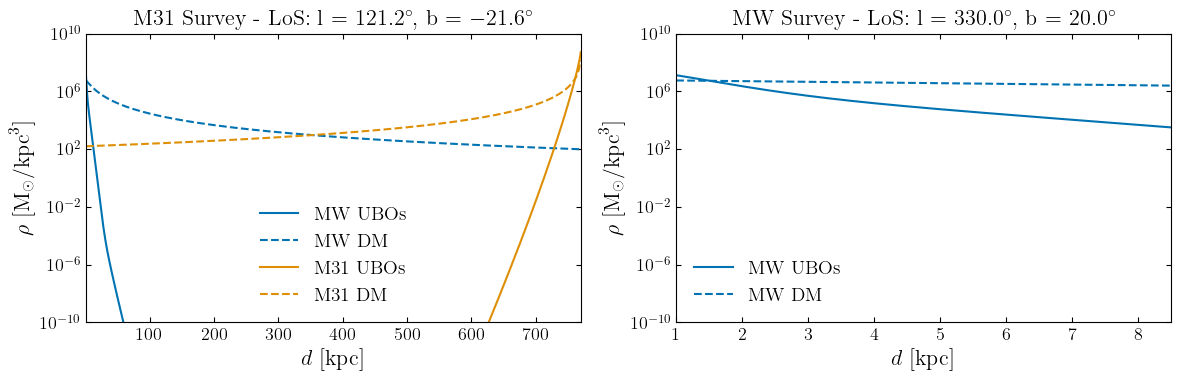

In [100]:
n_params = len(survey_param_dict)
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  

# Loop through the parameter sets and create subplots
for i, param_set in enumerate(survey_param_dict.values()):
    s = Survey(**param_set)
    ax = axes[i]
    plot_line_of_sight(s, ax)

plt.tight_layout()

In [123]:
#J-factor like metric to compare density of UBOs
def ubo_factor(s):
    #integrated density of UBOs along line of sight (not include finite size effects)
    d_arr = np.linspace(0, s.source_dist, 1000) #kpc
    rho_ffp_mw = [s.mw_model.density_stars(d) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
    
    rho_ffp_interp = interp1d(d_arr, rho_ffp_mw)
    rho_ffp_m31_interp = interp1d(d_arr, rho_ffp_m31)

    return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]

Expected number of events

In [81]:
t_es = np.logspace(-2, 1, 20) #hours

In [87]:
def get_n_events(s, p=1, finite=True):
    #get expected number of events for pdf-powerlaw. Note that you need to normalize this
    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    if s.cadence*2 > s.obs_time/2:
        raise ValueError("Cadence is too short relative to total observation time")
    #? using 2x the cadence and 1/2 the observation time for now. Comparable to Fig 18 of https://arxiv.org/pdf/1701.02151.pdf sensitivity
    dnds = quad(rate_interp, s.cadence*2, s.obs_time/2)[0]
    return s.n_sources*s.efficiency*dnds*s.obs_time

In [88]:
get_n_events(s)

3.5739868532563855e-13

In [101]:
def get_num_events_fiducial(s, finite=True):

    #power law, normalization, and normalization mass for fiducial mass function
    p = 1
    Z_fiducial = 10
    M_norm = 3e-6 #earth mass in solar mass units

    #number of events for a power law normalized to 1 UBO per star total
    n_events = get_n_events(s, p=p, finite=finite)

    #rescale normalization of pdf to M_norm = earth mass if not already
    z_earth = s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p) 

    #number of objects per star for fiducial mass function at 1 earth mass

    num_events_fiducial = n_events * Z_fiducial/z_earth

    return num_events_fiducial

In [104]:
num_events_dict = {}
for i, survey_name in enumerate(survey_param_dict.keys()):
    param_set = survey_param_dict[survey_name]
    s = Survey(**param_set)
    expected_num_events = get_num_events_fiducial(s)
    num_events_dict[survey_name] = expected_num_events


In [127]:
ubo_factor_dict = {}
for i, survey_name in enumerate(survey_param_dict.keys()):
    param_set = survey_param_dict[survey_name]
    s = Survey(**param_set)
    ubo_factor_dict[survey_name] = ubo_factor(s)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9893/2090357308.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9893/2090357308.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(rho_ffp_interp, 0, s.source_dist)[0] + quad(rho_ffp_m31_interp, 0, s.source_dist)[0]


In [161]:
# Create a list of dictionaries for the table
table_data = []
for survey_name, param_set in survey_param_dict.items():
    row = {
        "Survey": survey_name,
        "l": param_set["l"],
        "b": param_set["b"],
        "n_sources": param_set["n_sources"],
        "ubo_factor": ubo_factor_dict[survey_name],
        "obs_time": param_set["obs_time"],
        "num_expected_events_tot": num_events_dict[survey_name],
        "num_expected_events_per_hour": float(num_events_dict[survey_name]) / float(param_set["obs_time"]),
    }
    table_data.append(row)

df = pd.DataFrame(table_data)
df = df[["Survey", "l", "b", "n_sources", "ubo_factor", "obs_time", "num_expected_events_tot", "num_expected_events_per_hour"]]


In [163]:
# Define a function to format large numbers in scientific notation
def scientific_format(x):
    return '{:.4e}'.format(x)

# Apply styling to the DataFrame
styled_df = (
    df.style
    .format({
        'l': '{:.1f}',
        'b': '{:.1f}',
        'n_sources': '{:.1e}',
        'ubo_factor': '{:.1e}',
        'obs_time': '{:.1f}',
        'num_expected_events_tot': '{:.1e}',
        'num_expected_events_per_hour': '{:.1e}',
        
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
    .set_caption('Survey Parameters and Expected Events')
)

# Display the styled DataFrame
styled_df


,Survey,l,b,n_sources,ubo_factor,obs_time,num_expected_events_tot,num_expected_events_per_hour
0,hsc,121.2,-21.6,8.7e+07,9.5e+08,7.0,4.7e-03,6.7e-04
1,lsst,330.0,20.0,1.2e+06,3.6e+07,12.5,5.9e-05,4.7e-06
